# 🚀 Optimized CNN Model for Animal Image Classification

This notebook showcases an optimized CNN using `BatchNormalization`, `GlobalAveragePooling2D`, and a learning rate scheduler to improve classification performance on the Animals-10 dataset.


## 📦 1. Setup and Imports

In [15]:
import os
import zipfile
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Import load_img and img_to_array from tensorflow.keras.utils
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D,Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image

## 📁 2. Mount Drive and Extract Data

In [2]:
def mount_and_extract(zip_path, extract_to):
    if not os.path.exists(extract_to):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(os.path.dirname(extract_to))
        print(f"✅ Extracted: {os.path.basename(zip_path)}")

drive.mount('/content/drive')

mount_and_extract("/content/drive/MyDrive/IronHack/animals10.zip", "/content/animals10/raw-img")
mount_and_extract("/content/drive/MyDrive/IronHack/holdout.zip", "/content/animals10/holdout/raw-img")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Extracted: animals10.zip


## 🧼 3. Preprocessing with ImageDataGenerator

In [3]:
def prepare_data_generators(base_path, img_size=(128, 128), batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    # Point flow_from_directory to the directory containing the class subdirectories
    train = datagen.flow_from_directory(base_path, target_size=img_size, batch_size=batch_size, class_mode='categorical', subset='training')
    val = datagen.flow_from_directory(base_path, target_size=img_size, batch_size=batch_size, class_mode='categorical', subset='validation')
    return train, val

# Change the base_path to the directory containing 'raw-img' and then the class folders
train_gen, val_gen = prepare_data_generators("/content/animals10/animals10/raw-img")

Found 18856 images belonging to 10 classes.
Found 4709 images belonging to 10 classes.


## 🖼️ 4. Preview Sample Images

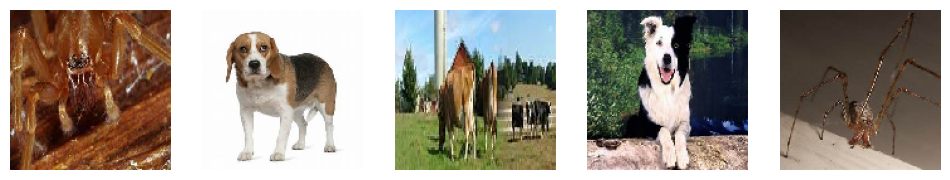

In [4]:
def preview_images(generator):
    imgs, _ = next(generator)
    plt.figure(figsize=(12, 4))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(imgs[i])
        plt.axis("off")
    plt.show()

preview_images(train_gen)

## 🏗️ 5. Define and Compile CNN Model

In [5]:
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(512, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

initial_learning_rate = 0.0005
model.compile(optimizer=Adam(initial_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,706,442 (6.51 MB)

 Trainable params: 1,704,458 (6.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

## 🚂 6. Train the Model

In [7]:
K.clear_session()
start_time = time.time()

lr_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[lr_plateau],
    verbose=1
)

training_time = time.time() - start_time
print(f"⏱️ Total Training Time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

model.save("/content/animal_classifier_v2.keras")
print("✅ Model saved as animal_classifier_v2.keras")

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


590/590 ━━━━━━━━━━━━━━━━━━━━ 50s 68ms/step - accuracy: 0.3484 - loss: 2.0433 - val_accuracy: 0.5090 - val_loss: 1.3915 - learning_rate: 5.0000e-04
Epoch 2/25
590/590 ━━━━━━━━━━━━━━━━━━━━ 32s 54ms/step - accuracy: 0.5686 - loss: 1.2990 - val_accuracy: 0.4825 - val_loss: 1.6119 - learning_rate: 5.0000e-04
Epoch 3/25
590/590 ━━━━━━━━━━━━━━━━━━━━ 33s 56ms/step - accuracy: 0.6496 - loss: 1.0443 - val_accuracy: 0.6328 - val_loss: 1.1397 - learning_rate: 5.0000e-04
Epoch 4/25
590/590 ━━━━━━━━━━━━━━━━━━━━ 31s 53ms/step - accuracy: 0.7088 - loss: 0.8662 - val_accuracy: 0.6485 - val_loss: 1.0485 - learning_rate: 5.0000e-04
Epoch 5/25
590/590 ━━━━━━━━━━━━━━━━━━━━ 31s 53ms/step - accuracy: 0.7533 - loss: 0.7254 - val_accuracy: 0.7284 - val_loss: 0.8504 - learning_rate: 5.0000e-04
Epoch 6/25
590/590 ━━━━━━━━━━━━━━━━━━━━ 32s 54ms/step - accuracy: 0.8223 - loss: 0.5490 - val_accuracy: 0.7292 - val_loss: 0.8667 - learning_rate: 5.0000e-04
Epoch 7/25
590/590 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy

## 📊 7. Evaluate Performance

In [9]:
# Evaluate on validation set
loss, accuracy = model.evaluate(val_gen)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

# Final training metrics
train_accuracy = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8119 - loss: 0.8790
Validation Accuracy: 81.99%
Validation Loss: 0.8431
Training Accuracy: 99.85%
Training Loss: 0.0074


## 📈8. Plot Accuracy and Loss

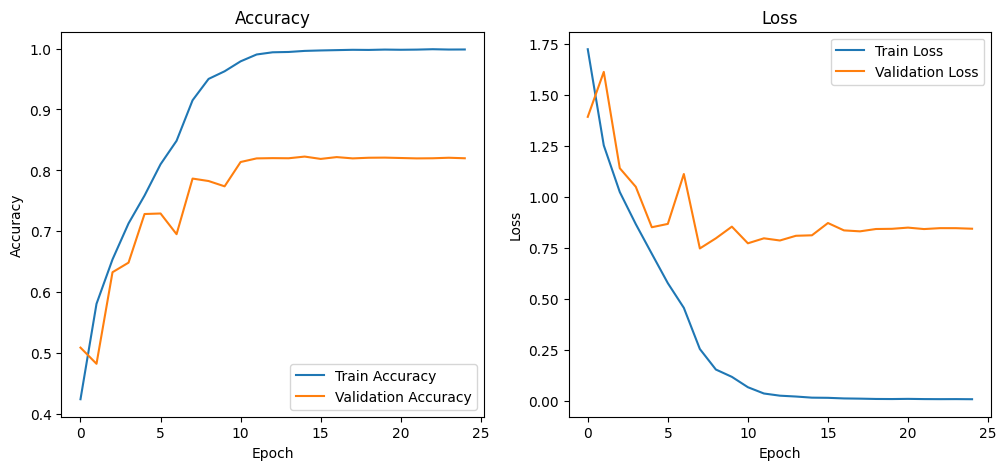

In [10]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 🧪9. Predict on Validation Set

In [12]:
from sklearn.metrics import classification_report

# Predictions
y_true, y_pred = [], []
class_labels = list(train_gen.class_indices.keys())

for images, labels in val_gen:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    if len(y_true) >= val_gen.samples:
        break

print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


📊 Classification Report:

              precision    recall  f1-score   support

   butterfly       0.87      0.81      0.84       380
         cat       0.79      0.71      0.75       300
     chicken       0.86      0.89      0.88       557
         cow       0.75      0.77      0.76       336
         dog       0.77      0.85      0.80       875
    elephant       0.82      0.77      0.80       260
       horse       0.81      0.82      0.81       472
       sheep       0.78      0.69      0.73       327
      spider       0.89      0.91      0.90       867
    squirrel       0.79      0.72      0.75       335

    accuracy                           0.82      4709
   macro avg       0.81      0.79      0.80      4709
weighted avg       0.82      0.82      0.82      4709



## 📈10. Confusion Matrix

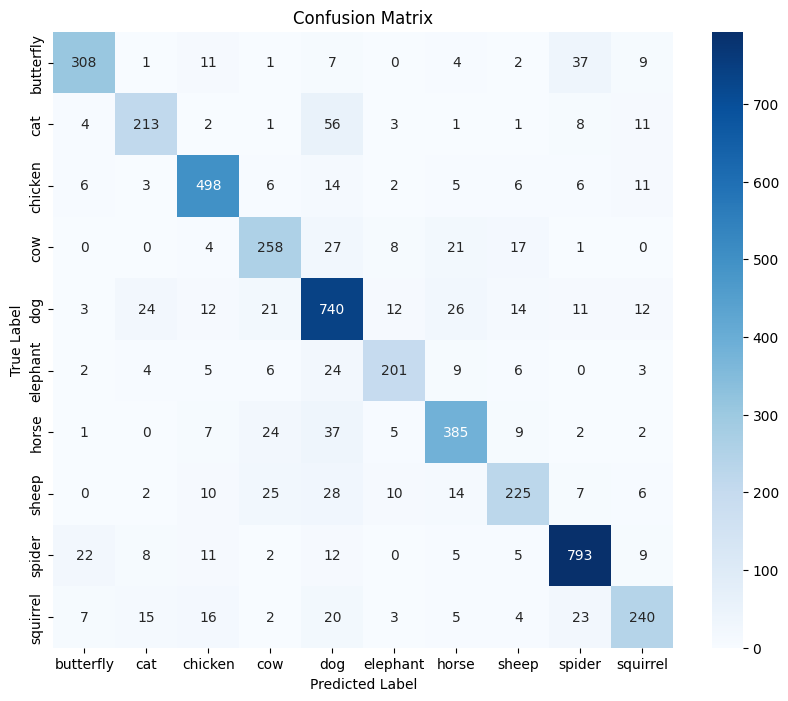

In [13]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 🔍 11. Predict on Holdout Set

In [16]:
class_labels = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
correct = 0
misclassified = []
total = 0

holdout_dataset_path = "/content/animals10/holdout/raw-img"

for class_name in os.listdir(holdout_dataset_path):
    class_folder = os.path.join(holdout_dataset_path, class_name)
    if not os.path.isdir(class_folder):
        continue
    for file in os.listdir(class_folder):
        if not file.lower().endswith(('jpg', 'jpeg', 'png')):
            continue

        img_path = os.path.join(class_folder, file)
        img = image.load_img(img_path, target_size=(128, 128))
        img_array = np.expand_dims(image.img_to_array(img), axis=0) / 255.
        pred = model.predict(img_array, verbose=0)
        pred_label = class_labels[np.argmax(pred)]
        total += 1
        if pred_label == class_name:
            correct += 1
        else:
            misclassified.append((img_path, class_name, pred_label))

acc = (correct / total) * 100 if total > 0 else 0
print(f"\n✅ Accuracy on Holdout Set: {acc:.2f}%")
print(f"🔢 Correct Predictions: {correct} / {total}")


✅ Accuracy on Holdout Set: 96.56%
🔢 Correct Predictions: 2271 / 2352


## 🖼️ 12. Display Misclassified Holdout Samples


❌ Showing 8 Misclassified Images:


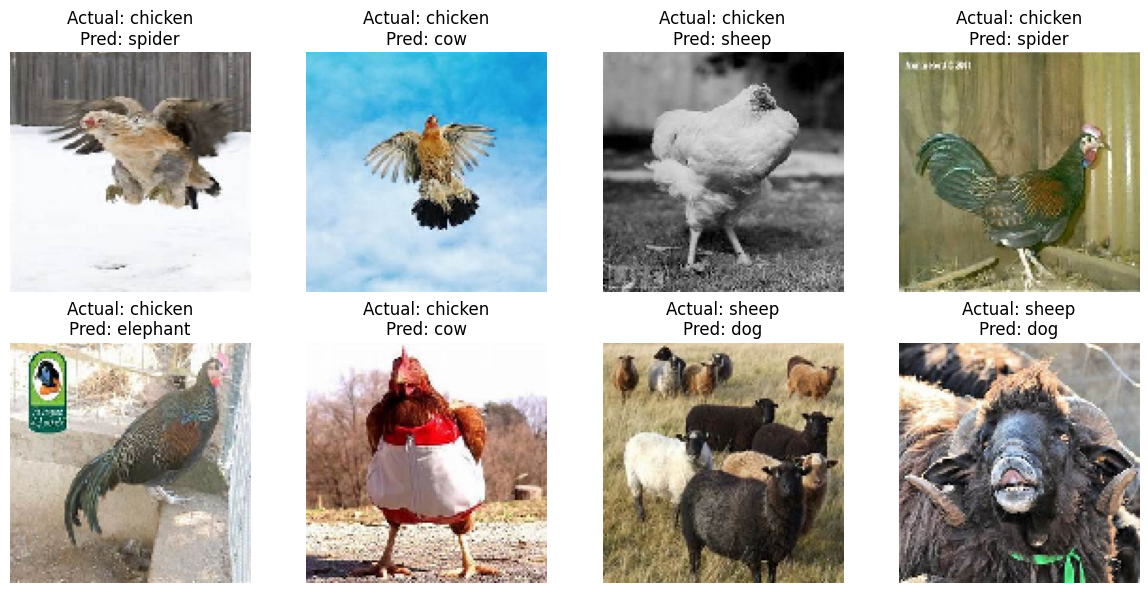

In [17]:
if misclassified:
    print(f"\n❌ Showing {min(8, len(misclassified))} Misclassified Images:")
    plt.figure(figsize=(12, 6))
    for i, (path, true, pred) in enumerate(misclassified[:8]):
        img = image.load_img(path, target_size=(128, 128))
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Actual: {true}\nPred: {pred}")
    plt.tight_layout()
    plt.show()
else:
    print("✅ No misclassifications found!")